<a href="https://colab.research.google.com/github/mrunalmania/Pytorch-Learning/blob/main/04_custom_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Importing PyTorch and setting up device agnostic code

### Domain Libraries
Depending on what you're working on, vision text, audio, recommendation system, you'll want to look into each of the python domain libraries for existing data loading functions and customizable data loading functions. 

In [195]:
import torch
from torch import nn
# Note: we need pytorch 1.10.0+ required for this course

torch.__version__


'2.0.0+cu118'

In [196]:
# set up device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [197]:
!nvidia-smi

Sun May  7 23:00:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    27W /  70W |   2481MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1. Get data

Our dataset is a subset of food101 dataset.

Food101 starts 101 different classes of food and 1000 images per class (750 training , 250 testing)

Our dataset starts with 3 classes of food. and only 10% of the images (~75 training ,25 testing)

Why do this?
When starting our ML model, it's important to try things on a small scale and then increase the scale when necessary.

The whole point is to speed up how fast you can experiment.




In [198]:
import requests
import zipfile
from pathlib import Path

# Set up a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory already exists...skipping download")
else:
  print(f"{image_path} doesn't exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data

with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print(f"downloading pizza, steak, sushi data....")
  f.write(request.content)

with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza. steak, sushi data")
  zip_ref.extractall(image_path)



data/pizza_steak_sushi directory already exists...skipping download
downloading pizza, steak, sushi data....
Unzipping pizza. steak, sushi data


## 2. Becoming one with the data (data preparation and data exploration)

In [199]:
import os
def walk_through_dir(dir_path):
  """ Walks through dir_path returning its contents """

  for dirpath, dirnames,filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}" )

In [200]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak


In [201]:
# setup train and test paths
train_dir = image_path/ "train"
test_dir = image_path/ "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 visualizing an image

let's write some code to:
1. Get all of the image paths
2. Pick a random image path using python's random.choice()
3. Get the image class name using `pathlib.Path.parent.stem`

4. Since we're working with images let's open the image with PIL (Python image library)

5. We'll show the image and print metadata.

data/pizza_steak_sushi/test/sushi/499605.jpg
sushi
 Random image path = : data/pizza_steak_sushi/test/sushi/499605.jpg
 Image class: sushi
 Image width: 512
 Image height: 512


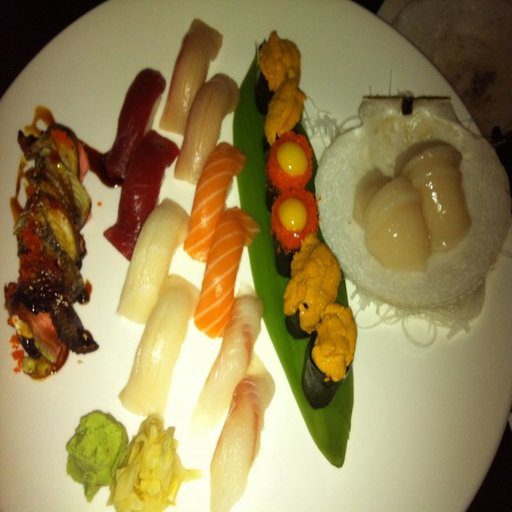

In [202]:
import random
from PIL import Image

# set seed
# random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick random image_path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get the image class from the path name (image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
print(image_class)

# 4 Open up the image
img = Image.open(random_image_path)

# 5. Print the image metadata

print(f" Random image path = : {random_image_path}")
print(f" Image class: {image_class}")
print(f" Image width: {img.width}")
print(f" Image height: {img.height}")

img

(-0.5, 511.5, 511.5, -0.5)

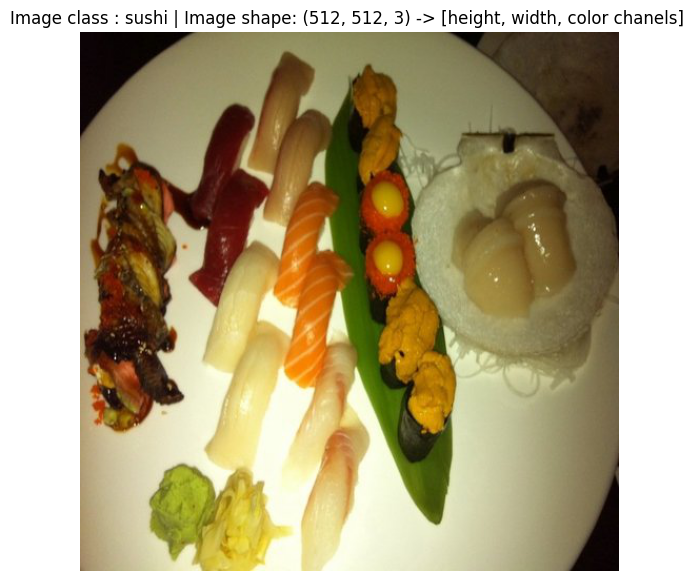

In [203]:
import numpy as np
import matplotlib.pyplot as plt

# turn the image into an arrat
img_as_array = np.asarray(img)

# plot the image 
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class : {image_class} | Image shape: {img_as_array.shape} -> [height, width, color chanels] ")
plt.axis(False)

In [204]:
img_as_array

array([[[ 12,   3,   6],
        [ 12,   3,   6],
        [ 12,   3,   6],
        ...,
        [ 42,  25,  17],
        [ 44,  27,  19],
        [ 45,  28,  20]],

       [[ 12,   3,   6],
        [ 12,   3,   6],
        [ 12,   3,   6],
        ...,
        [ 43,  26,  18],
        [ 45,  28,  20],
        [ 46,  29,  21]],

       [[ 12,   3,   6],
        [ 12,   3,   6],
        [ 12,   3,   6],
        ...,
        [ 45,  28,  20],
        [ 46,  29,  21],
        [ 46,  29,  21]],

       ...,

       [[140, 116,  82],
        [146, 122,  88],
        [151, 127,  93],
        ...,
        [ 10,   4,   4],
        [ 10,   4,   4],
        [ 10,   4,   4]],

       [[135, 111,  77],
        [142, 118,  84],
        [148, 125,  91],
        ...,
        [ 10,   4,   4],
        [ 11,   5,   5],
        [ 11,   5,   5]],

       [[133, 109,  75],
        [140, 116,  82],
        [146, 123,  89],
        ...,
        [ 11,   5,   5],
        [ 12,   6,   6],
        [ 13,   7,   7]]

## 3. Transforming data

Before we can use our image data with pytorch: 

1. Turn your target data into tensors (numerical reprensatation of our images)

2. Turn it into a `torch.utils.data.Dataset` and subseqently a `torch.utils.data.DataLoader`.



In [205]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

to combine multiple transforms we can use `transforms.compose` or `nn.Sequential`.

Transforms help you get your images ready to be used with a model/perform data augmentation.


In [206]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize the images to 64X64
    transforms.Resize(size=(64,64)),

    # Flip the images to horizonatal flip randomaly
    transforms.RandomHorizontalFlip(p=0.5),

    # Convert the PIL image to torch.tensor
    transforms.ToTensor()
]) 

In [207]:
tensor_image = data_transform(img)
tensor_image, tensor_image.shape, tensor_image.dtype

(tensor([[[0.0471, 0.0471, 0.0431,  ..., 0.2157, 0.2039, 0.1882],
          [0.0471, 0.0471, 0.0431,  ..., 0.2118, 0.2078, 0.2039],
          [0.0471, 0.0471, 0.0431,  ..., 0.2157, 0.2000, 0.2000],
          ...,
          [0.6588, 0.6941, 0.7137,  ..., 0.0510, 0.0471, 0.0471],
          [0.6510, 0.6824, 0.7098,  ..., 0.0471, 0.0471, 0.0392],
          [0.6275, 0.6667, 0.7020,  ..., 0.0471, 0.0431, 0.0392]],
 
         [[0.0118, 0.0118, 0.0118,  ..., 0.1529, 0.1412, 0.1216],
          [0.0118, 0.0118, 0.0118,  ..., 0.1569, 0.1451, 0.1373],
          [0.0118, 0.0118, 0.0078,  ..., 0.1490, 0.1373, 0.1333],
          ...,
          [0.5725, 0.6157, 0.6510,  ..., 0.0157, 0.0157, 0.0118],
          [0.5569, 0.6039, 0.6431,  ..., 0.0118, 0.0118, 0.0157],
          [0.5373, 0.5961, 0.6353,  ..., 0.0118, 0.0078, 0.0118]],
 
         [[0.0235, 0.0235, 0.0157,  ..., 0.1020, 0.0941, 0.0863],
          [0.0235, 0.0235, 0.0157,  ..., 0.1020, 0.0980, 0.0980],
          [0.0235, 0.0235, 0.0157,  ...,

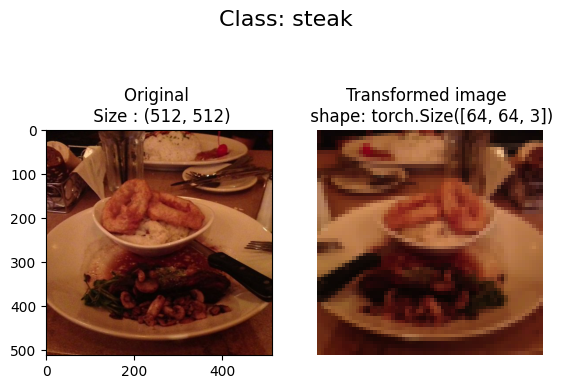

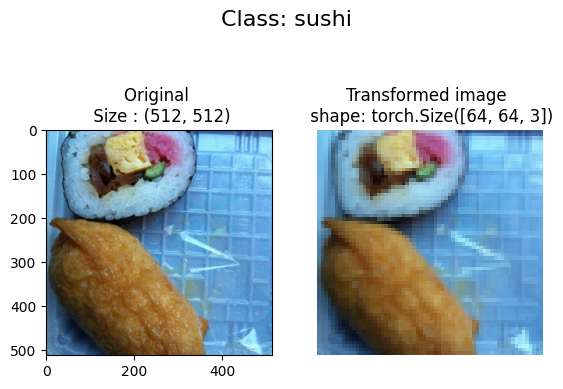

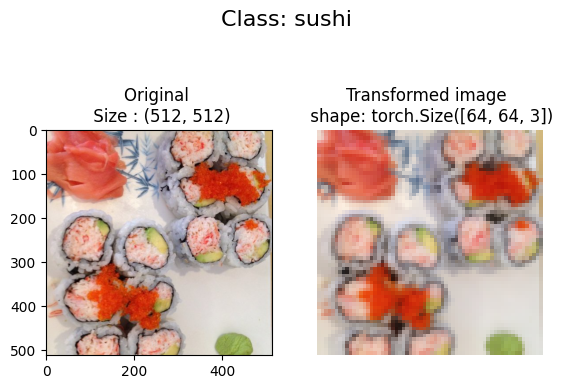

In [208]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
  """
  Selects random images from a path of images and loads/transforms then 
  plots the original vs the transformed version.
  
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths,k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \n Size : {f.size}")

      # Transform and plot target image
      transformed_image = transform(f).permute((1,2,0)) # Note we will need to change shape, because with transform we get color chanel first, but matplotlib needs the color chanel lasts.
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed image \n shape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)
plot_transformed_images(image_paths= image_path_list, transform = data_transform,
                        n=3,
                        seed=42)





## 4. Option 1: Loading image data using `ImageFolder`

We can load the image classification data using `torchvision.datasets.ImageFolder`

In [209]:
# Use ImageFolder to create dataset(s)

from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform = data_transform, # transform for the data
                                  target_transform = None # transform for the label/target
                                  )
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform= None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [210]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [211]:
# Get class names as a list
class_names = train_data.classes

class_names

['pizza', 'steak', 'sushi']

In [212]:
# Get the class names as a dictionary
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [213]:
# Check the length of the datasets
len(train_data), len(test_data)

(225, 75)

In [214]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [215]:
# Index on the train_data Datasets to get a single image and label
img, label = train_data[0][0], train_data[0][1]
img

tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0706, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0196, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0157, 0.0157, 0.

In [216]:
label

0

In [217]:
class_names[label]

'pizza'

In [218]:
print(f"Image Tensor: \n {img}")
print(f"Image shape: \n {img.shape}")
print(f"Image datatype \n {img.dtype}")
print(f"Image label: \n {label}")
print(f"Label data type: \n {type(label)}")

Image Tensor: 
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0706, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0196, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.

In [219]:
# Rearrange order of dimension , so that we can print image on matplotlib
img_permute = img.permute(1,2,0)
print(f"Original shape: {img.shape} -> [colorchanel, height, width]")
print(f"Image permute: {img_permute.shape} -> [height,width,colorchanel]")

Original shape: torch.Size([3, 64, 64]) -> [colorchanel, height, width]
Image permute: torch.Size([64, 64, 3]) -> [height,width,colorchanel]


Text(0.5, 1.0, 'pizza')

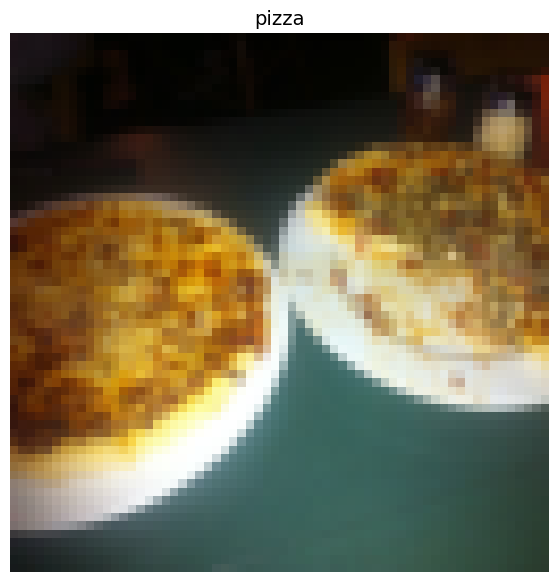

In [220]:
# plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis('off')
plt.title(class_names[label], fontsize=14)

### 4.1 Turn loaded images to data loader

A `DataLoader` is going to help us turn our `Datasets` into iterables and we can customize the batch size so our model can see `batch_size` images at a time. 

In [221]:
import os
os.cpu_count()

2

In [222]:
from torch.utils.data import DataLoader

BATCH_SIZE = 1


# train data loadder
train_dataloader = DataLoader(train_data,batch_size=BATCH_SIZE,num_workers = 1,shuffle=True)

# test data loader
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE,num_workers=1, shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f8c6ce7b280>,
 <torch.utils.data.dataloader.DataLoader at 0x7f8c6ce7b430>)

In [223]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [224]:
img , label = next(iter(train_dataloader))
# Batch size will now be 1, you can change the batch size if you like
print(f" Image shape: {img.shape} -> [batch size, color channels, height, width]")
print(f" Label shape: {label.shape}")

 Image shape: torch.Size([1, 3, 64, 64]) -> [batch size, color channels, height, width]
 Label shape: torch.Size([1])


## 5 Option 2: Loading image data with custom datasets

1. Want to be able to load images from file

2. Want to be able to get class names from the Dataset.

3. Want to be able to get classes dictionary from the datsets.


Pros: 
* Can create a `Dataset` out of almost anything.

* Not limited to pytorch pre-built `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost anything, it doesn't meant it will work...

* Using a custom `Dataset` often reslts in us writing more code, which could be prone to errors or performance issues.


All custom datasets in PyTorch, often subclass - torch.utils.data.Dataset

In [225]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset

from torchvision import transforms
from typing import Tuple,Dict,List


In [226]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We want a function to: 
1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format)

2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the direcotry structure).
3. Turn the class names into a dict and a list and return them.

In [227]:
# Setup path for target directory.
target_directory = train_dir
print(f"Target dir: {target_directory}")


# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found


Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [228]:
list(os.scandir(target_directory))

[<DirEntry 'sushi'>, <DirEntry 'pizza'>, <DirEntry 'steak'>]

In [229]:
import enum
def find_classes(directory: str) -> Tuple[List[str], Dict[str,int]]:
  """ Finds the classes folder names in a target directory."""

  # 1. Get the class names by scaning the target directory.
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
  
  # 2. Raise an error if class names not found
  if not classes:
    raise FileNotFoundError(f"Could not fnd any classes in {directory} please check file strucuture...")
  
  # 3. Create a dictionary of index labels (Computers prefers numbers rather than strings as a label)
  class_to_idx = {class_name: i for i , class_name in enumerate(classes)}

  return classes , class_to_idx


In [230]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate ImageFolder

To create our own custmom dataset, we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get from) as well as a transform if we'd like to transform our data.
3.  Create several attributes:
  * Paths - paths of our images
  * transform - the transform we'd like to use
  * classes - a list of target classes
  * class_to_idx - a dict of target classes mapped to integer label.

4. Create a function to `load_images()`, this function will open an image.

5. Overwrite the `__len()__` method to return the length of our dataset

6. Overwrite the `__getitem()__` method to return a given sample when passed an index.


In [231]:
# 0. Write a custom dataset class

from torch.utils.data import Dataset
from PIL import Image

# 1. Subclass the torch.util.data.Dataset

class ImageFolderCustom(Dataset):
  # 2. intialize our custom dataset
  def __init__(self, targ_dir: str, transform = None) -> None:
    super().__init__()

    # 3.  Create class attribte
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # Setup transforms 
    self.transform = transform

    # Create classes and class_to_idx
    self.classes , self.class_to_idx = find_classes(targ_dir)
  
  # 4. Create a function to load_images
  def load_image(self,index:int) -> Image.Image:
    """ Opens an image via path and returns it."""

    image_path = self.paths[index]
    return Image.open(image_path)
  
  # 5. overwrite __len__()
  def __len__(self) -> int:
    """ Returns the total number of samples."""
    return len(self.paths)

  # 6. overwrite __getitem__()
  def __getitem__(self,index: int)-> Tuple[torch.Tensor, int]:
    """ Returns one sample of data, data and label (X,y)."""

    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx # return data, label(X,y)
    else:
      return img, class_idx # return untransformed image and label
     


In [232]:
# create a transform
from torchvision import transforms
train_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [233]:
from matplotlib.transforms import Transform
# Test out ImageFolederCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform = train_transform)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform = test_transform)

In [234]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7f8c6ce78bb0>,
 <__main__.ImageFolderCustom at 0x7f8c6ce7a830>)

In [235]:
len(train_data) , len(train_data_custom)

(225, 225)

In [236]:
len(test_data), len(test_data_custom)

(75, 75)

In [237]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [238]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [239]:
# Check for a equality between original ImageFolder Dataset and ImageFolderCustomDataset

print(train_data.classes == train_data_custom.classes)
print(test_data.classes == test_data_custom.classes)

True
True


### 5. 3 Create a function to display random images

1. Take in a dataset and a number of other parameters such as class names and how images to visualize.

2. To prevent the display getting out of hand, let's cap  the number of images to see at 10.

3. Set the random seed for reproducibility.

4. Get a list of random sample indexes from the target dataset.

5. setup a matplotlib plot.

6. Loop through the random sample images and plot them with matplotlib.

7. Make sure the dimensions of our images lines up with matplotlib (HWC)



In [240]:

# 1. Create a function to take dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # Adjust the display if n is too high
  if n > 10:
    n = 10;
    display_shape = False
    print(f"For display, purposes, n shouldn't be larger than 10, setting to 10 and removing shape display")

  # 3. Set the seed
  if seed:
    random.seed(seed)
  
  # 4. get random sample indexes
  random_sample_idx = random.sample(range(len(dataset)), k=n)

  # 5. setup plot
  plt.figure(figsize=(16,8))

  # 6. Loop through the random indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_sample_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust tensor dimesions for plotting
    targ_image_adjust = targ_image.permute(1,2,0) # [color,hright,width] -> [height,width, color]

    #Plot adjusted samples
    plt.subplot(1,n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title+= f"\nShape:{targ_image_adjust.shape}"
    plt.title(title)




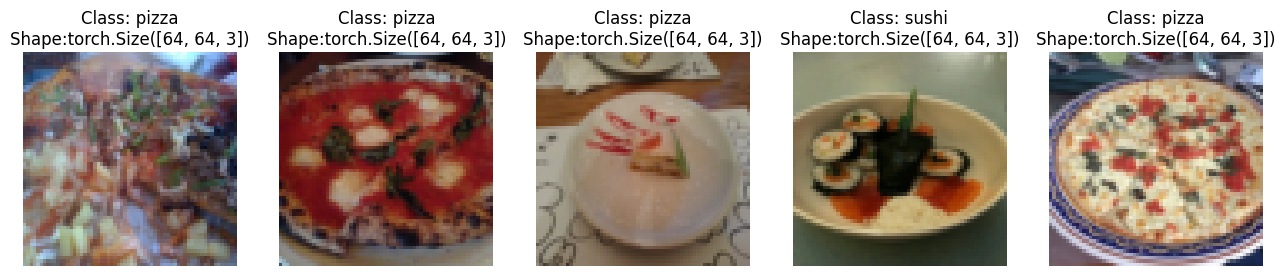

In [241]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes = class_names,
                      seed = None)

For display, purposes, n shouldn't be larger than 10, setting to 10 and removing shape display


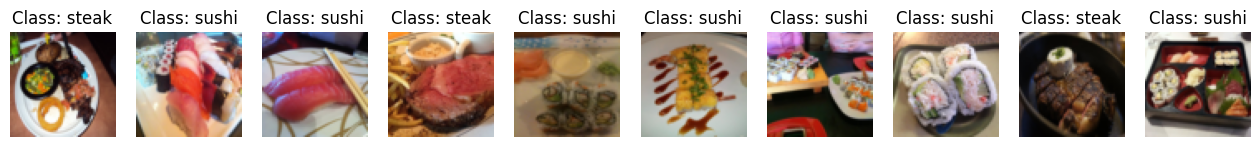

In [242]:
# Display random images from the ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=20,
                      classes=class_names,
                      seed=42)

### 5.4 Turn datasets to dataloader

In [243]:
from torch.utils.data import dataloader

BATCH_SIZE = 1
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(train_data_custom,batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

test_dataloader_custom = DataLoader(test_data_custom, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7f8c6cf61780>,
 <torch.utils.data.dataloader.DataLoader at 0x7f8c6cf61930>)

In [244]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))
img_custom.shape, label_custom.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

## 6. Other forms of transforms (Data Augmentation)

Data augmentation is the process of artificially adding diversity to your training data.


In the case of Image data, this may applying various image transformations to the training images.

This practice hopefully results in a models that's more generalizable to unseen data.

Let's take a look at one particular type of data augmentation used to train PyTorch vision models of state-of-the-art levels.

Blogpost: https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

Please read blogpost (20-30 mins),



In [245]:
# Lets look at trivial augment

from torchvision import transforms
train_transforms = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # num_magnitude_bins -> how intense you wantaugmentation to happen (range 0 to 31)
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

In [246]:
# Get all the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[0:10]

[PosixPath('data/pizza_steak_sushi/test/sushi/3837522.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2190404.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1987407.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2521706.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2394442.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/3177743.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2715127.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1172255.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/3196729.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/479711.jpg')]

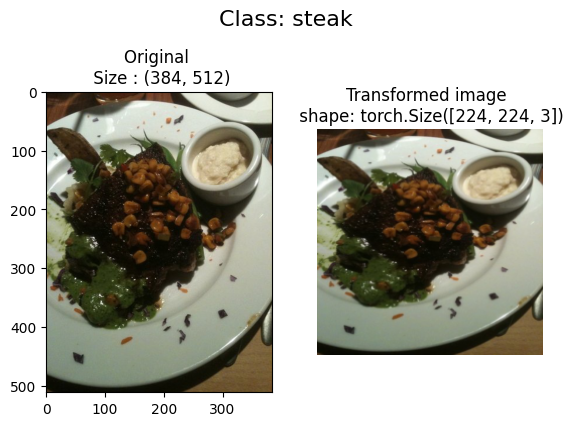

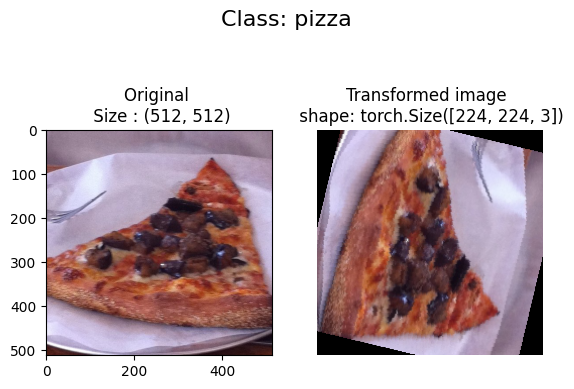

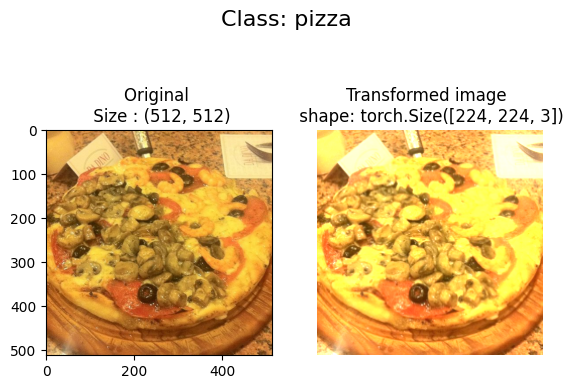

In [247]:
plot_transformed_images(
    image_paths = image_path_list,
    transform = train_transforms,
    n=3,
    seed=None
)

## 7. Model 0: TinyVGG without data augmentation 

Let's replicate TinyVGG architecutre from the CNN explainer 

### 7.1 Creating transforms and loading data from model 0

In [248]:
# create simple transform

simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])


In [249]:
# 1. Load and transform data.

from torchvision import datasets

train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform = simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform = simple_transform)

# 2. Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader

# setup batchsize and num_workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create dataloader
train_dataloader_simple = DataLoader(dataset = train_data_simple,
                                     batch_size = BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

### 7.2 Create tinyVGG model class


In [250]:
from torch.nn.modules.pooling import MaxPool1d
from torch.nn.modules.activation import ReLU
class TinyVGG(nn.Module):
  """ Model architecure copying TinyVGG from CNN Explainer """

  def __init__(self, input_shape:int, hidden_units:int, output_shape:int)-> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default sitrde value is same as kernel size.
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default sitrde value is same as kernel size.
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=13*13*hidden_units,
                  out_features=output_shape)
    )

  def forward(self,x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x

    # return self.classifier(self.conv_block_2(self.conv_block_1(x))) benefits from operator fusion.
    # read https://horace.io/brrr_intro.html

In [251]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units = 10,
                  output_shape = len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 try a forward pass on a single image (to test the model)

In [252]:
# get a single image batch
image_batch, label_batch  = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [253]:
model_0(image_batch.to(device))

tensor([[ 2.0789e-02, -1.9351e-03,  9.5317e-03],
        [ 1.8427e-02,  2.4670e-03,  6.6757e-03],
        [ 1.7699e-02,  1.0262e-03,  9.4657e-03],
        [ 2.4441e-02, -3.3526e-03,  9.6011e-03],
        [ 1.9930e-02,  6.6316e-04,  1.0779e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0999e-02,  1.2869e-04,  1.2473e-02],
        [ 2.1577e-02, -1.9507e-03,  9.6941e-03],
        [ 2.4504e-02, -4.7745e-03,  8.5280e-03],
        [ 2.0252e-02, -4.7292e-04,  1.0908e-02],
        [ 2.2215e-02, -4.1837e-04,  9.8123e-03],
        [ 2.2313e-02, -2.1622e-03,  9.4456e-03],
        [ 2.1841e-02, -3.7132e-03,  8.3783e-03],
        [ 2.2863e-02, -1.7723e-03,  1.0287e-02],
        [ 2.1647e-02, -4.4139e-03,  9.5021e-03],
        [ 2.2096e-02, -4.1426e-03,  9.3853e-03],
        [ 2.1209e-02, -4.4218e-03,  1.1475e-02],
        [ 2.1711e-02, -2.7656e-03,  8.5006e-03],
        [ 1.9951e-02,  2.8272e-05,  8.4380e-03],
        [ 1.8298e-02,  1.6306e-03,  8.5499e-03],
        [ 2.0768e-02

In [254]:
# Install TorchInfo, import it if its available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1,3,64,64])

/usr/local/lib/python3.10/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.10/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### 7.5 Create train and test loop functions

* `train_step()` - takes in a model and dataloader and trains the model on the `dataloader`.

* `test_step()` - takes in a model and dataloader to evaluate the model on the `dataloader`.


In [255]:
# Create train_step()

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
  # Put the model in train mode.
  model.train()

  # Setup train loss and train accuracy values.
  train_loss, train_acc = 0,0

  # loop through dataloader data batches
  for batch , (X,y) in enumerate(dataloader):
    # Send the data to the target device
    X,y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model_0(X)

    # 2. Calculate the loss
    loss = loss_fn(y_pred,y)
    train_loss+=loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1),dim=1)

    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  # Adjust metrics to get the avg loss and accuracy per batch
  train_loss = train_loss/len(dataloader)
  train_acc = train_acc/len(dataloader)
  return train_loss, train_acc




In [256]:
# Create a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  model.eval()

  # Set up testloss and testacc values
  test_loss, test_acc = 0,0

  # Turn on inference mode
  with torch.inference_mode():
    # Loop through dataloader batches
    for batch, (X,y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate the loss
      loss = loss_fn(test_pred_logits,y)
      test_loss += loss.item()

      # Calculate the accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += (test_pred_labels==y).sum().item()/len(test_pred_labels)

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss/len(dataloader)
  test_acc = test_acc/len(dataloader)
  return test_loss, test_acc



### 7.6 Creating `train()` function to combine `train_step()` and `test_step()`

In [257]:
from tqdm.auto import tqdm

# 1. Create a tran function that takes in various model parameter + optimizer + dataloader + loss function
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device = device
          ):
  # 2. Create empty result dictionary.
  results = {"train_loss" : [],
             "test_loss" : [],
             "train_acc": [],
             "test_acc" : []}
  for epoch in range(epochs):
    train_loss, train_acc = train_step(model=model,
                                       dataloader = train_dataloader,
                                       loss_fn = loss_fn,
                                       optimizer = optimizer,
                                       device = device)
    test_loss , test_acc = test_step(model=model,
                                     dataloader= test_dataloader,
                                     loss_fn = loss_fn,
                                     device=device)
    # 4. Print out what's happenin
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    # 5. Update our result dictionary.
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
  
  # Return the filled results at the end of the epochs
  return results

  

### 7.7 Train and evaluate model 0


In [258]:
# Set the random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels of target images
                  hidden_units = 10,
                  output_shape=len(train_data.classes)).to(device)

# Set the loss function and optimizer
loss_fn_model_0 = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr = 0.001)

# Start the timerr
from timeit import default_timer as timer
start_time = timer()


# Train model 0
model_0_results = train(model= model_0,
                        train_dataloader = train_dataloader_simple,
                        test_dataloader = test_dataloader_simple,
                        loss_fn = loss_fn_model_0,
                        optimizer = optimizer,
                        epochs= NUM_EPOCHS,
                        device=device)
# End the timer
end_time = timer()

print(f"Total training time: {end_time-start_time:.3f} seconds")

Epoch: 0 | Train loss: 1.1063 | Train acc: 0.3047 | Test loss: 1.0983 | Test acc: 0.3116
Epoch: 1 | Train loss: 1.0995 | Train acc: 0.3320 | Test loss: 1.0699 | Test acc: 0.5417
Epoch: 2 | Train loss: 1.0863 | Train acc: 0.4922 | Test loss: 1.0800 | Test acc: 0.5227
Epoch: 3 | Train loss: 1.0826 | Train acc: 0.4102 | Test loss: 1.0599 | Test acc: 0.5729
Epoch: 4 | Train loss: 1.0630 | Train acc: 0.4141 | Test loss: 1.0609 | Test acc: 0.5540
Total training time: 10.310 seconds


In [259]:
model_0_results

{'train_loss': [1.1063424050807953,
  1.0994839370250702,
  1.086288571357727,
  1.0826249867677689,
  1.0630027651786804],
 'test_loss': [1.0983142852783203,
  1.0698524316151936,
  1.0800262689590454,
  1.0598587195078533,
  1.060932199160258],
 'train_acc': [0.3046875, 0.33203125, 0.4921875, 0.41015625, 0.4140625],
 'test_acc': [0.31155303030303033,
  0.5416666666666666,
  0.5227272727272728,
  0.5729166666666666,
  0.5539772727272728]}

### 7.8 Plot the loss curves of model 0

A **loss curve** is a way of tracking your model's progress over time.

A good guide : https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic


In [260]:
model_0_results.keys()

dict_keys(['train_loss', 'test_loss', 'train_acc', 'test_acc'])

In [261]:
def plot_loss_curves(results: Dict[str,List[float]]):
  """ Plots training curves of result dictionary"""
  # get the loss values of results dictionary (training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # get the accuracy of values of results dictionary (training and test)
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Figure out how many epochs there were
  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15,7))

  # plot the loss
  plt.subplot(1,2,1)

  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label="train_acc")
  plt.plot(epochs, test_accuracy, label="test_acc")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()



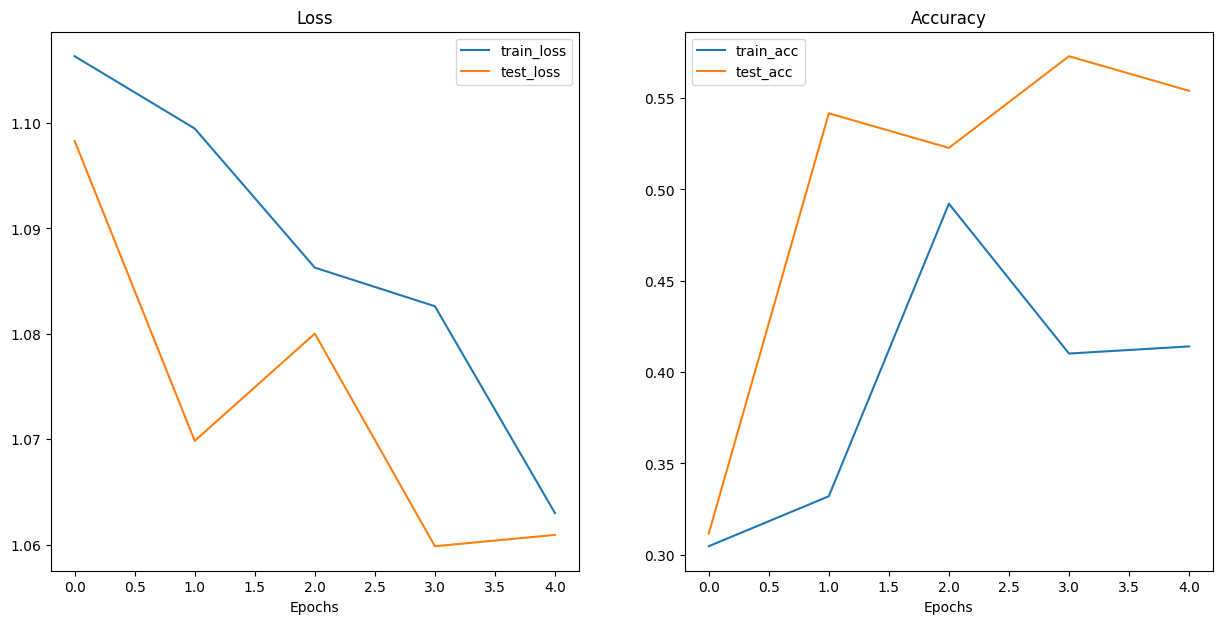

In [262]:
plot_loss_curves(model_0_results)

## 9. Model 1: TinyVGG with data augmentation

Now let's try another modelling experiment, this time using the same model as before with some data augmentation


### 9.1 Create Transform with data augmentation

In [263]:
# create training transform with TrivialAugment
from torchvision import transforms
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
]
)

### 9.2 Create a train and test `Dataset`'s and `DataLoader`'s with data augmentation

In [264]:
# Turn image folders into datasets.
train_data_augmented = datasets.ImageFolder(root = train_dir,
                                            transform = train_transform_trivial)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform = test_transform_simple)



In [265]:
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)

train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size= BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)


### 9.3 Construct and train model 1

This time we'll be using the same model architecutre except this time we using augmented data.


In [266]:
# Create model 1 and send it to the target device.

torch.manual_seed(42)

model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

Wonderful!! , Now we've a model and dataloaders, let's create a loss function and an optimizer and call upon our `train()` function to train and evaluate our model.

In [267]:
# Set random seeds.

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 5

# set up loss function
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr= 0.001)
from timeit import default_timer as timer
# Start the timer
start_time = timer()

# train model 1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader= test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_function,
                        epochs=NUM_EPOCHS,
                        device=device)

# End the timer
end_time = timer()

print(f"total training time for model_1 : {end_time-start_time}")
 

Epoch: 0 | Train loss: 1.0776 | Train acc: 0.3828 | Test loss: 1.0976 | Test acc: 0.2604
Epoch: 1 | Train loss: 1.0940 | Train acc: 0.4297 | Test loss: 1.0976 | Test acc: 0.2604
Epoch: 2 | Train loss: 1.0481 | Train acc: 0.4258 | Test loss: 1.0976 | Test acc: 0.2604
Epoch: 3 | Train loss: 1.0525 | Train acc: 0.5195 | Test loss: 1.0976 | Test acc: 0.2604
Epoch: 4 | Train loss: 1.0551 | Train acc: 0.4297 | Test loss: 1.0976 | Test acc: 0.2604
total training time for model_1 : 10.66524403800031


In [268]:
model_1_results

{'train_loss': [1.0775806605815887,
  1.0940090641379356,
  1.0481332316994667,
  1.0525401681661606,
  1.0550997108221054],
 'test_loss': [1.0976054271062214,
  1.0976054271062214,
  1.0976054271062214,
  1.0976054271062214,
  1.0976054271062214],
 'train_acc': [0.3828125, 0.4296875, 0.42578125, 0.51953125, 0.4296875],
 'test_acc': [0.2604166666666667,
  0.2604166666666667,
  0.2604166666666667,
  0.2604166666666667,
  0.2604166666666667]}

### 9.4 Plot the loss curves of model 1

A loss curve helps you evaluate your models performance overtime.

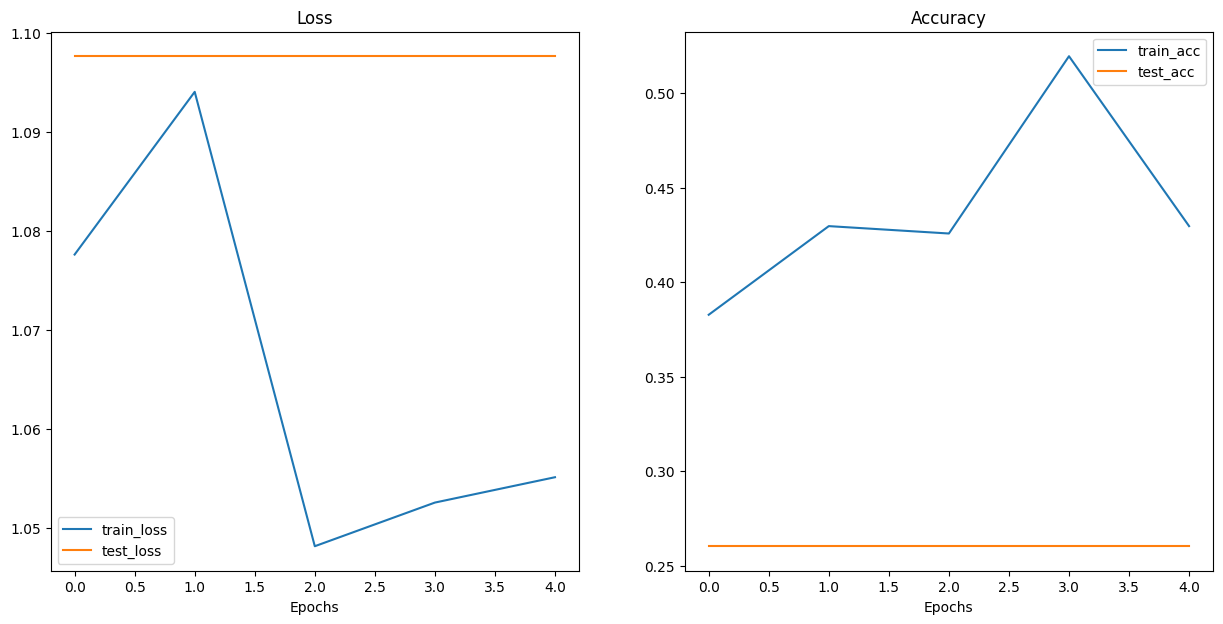

In [269]:
plot_loss_curves(model_1_results)

## 10. Compare model results

 After evaluating our modelling experiments on their own, its important to compare them to each other.

 There's a few different ways to do this:
 1. Hard coding (what we're doing)
 2. Pytorch + Tensorboard 
 3. Weights & Biases https://wandb.ai/site
 4. MLFlow - https://mlflow.org/





In [270]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)

model_0_df

train_loss  test_loss  train_acc  test_acc
0    1.106342   1.098314   0.304688  0.311553
1    1.099484   1.069852   0.332031  0.541667
2    1.086289   1.080026   0.492188  0.522727
3    1.082625   1.059859   0.410156  0.572917
4    1.063003   1.060932   0.414062  0.553977

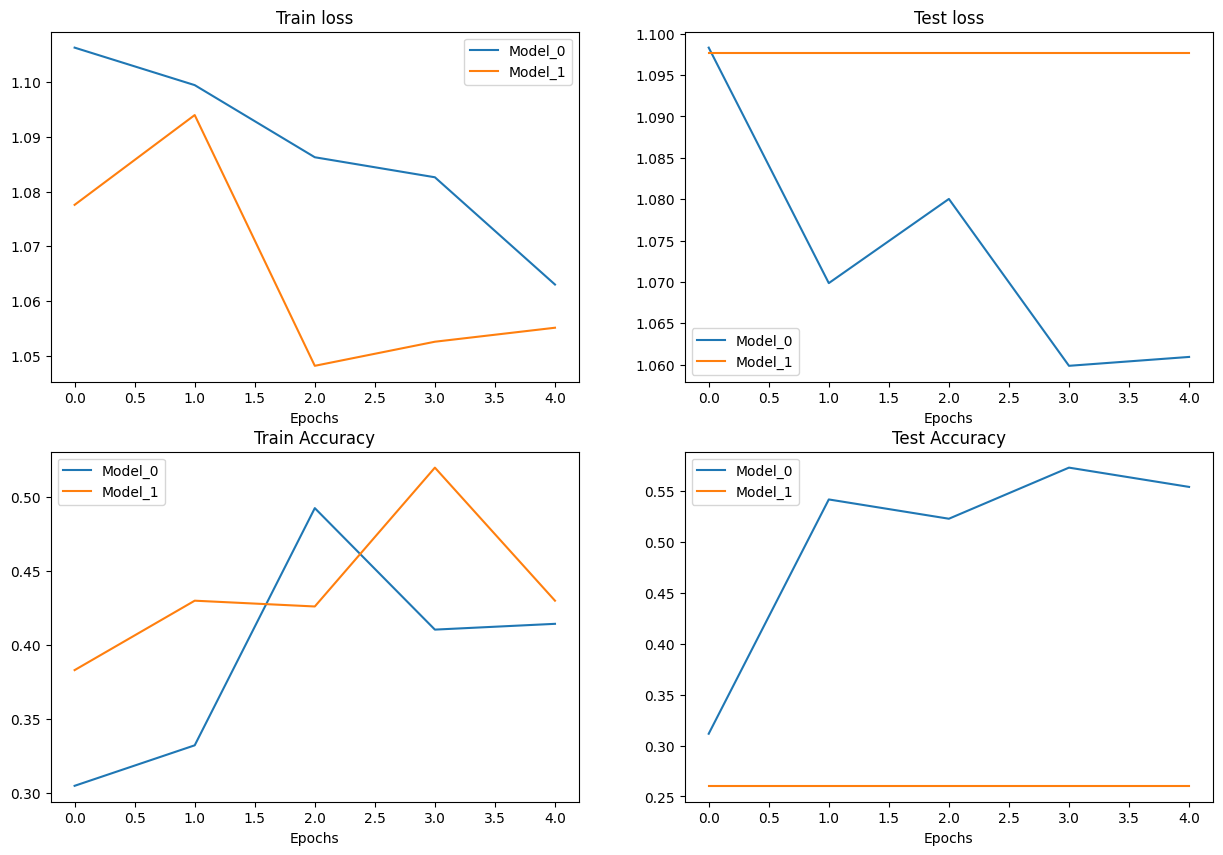

In [271]:
# setup a plot
plt.figure(figsize=(15,10))

# Get number of epochs
epochs = range(len(model_0_df))

# plot the train loss
plt.subplot(2,2,1)
plt.plot(epochs,model_0_df['train_loss'], label="Model_0")
plt.plot(epochs, model_1_df['train_loss'], label="Model_1")
plt.title("Train loss")
plt.xlabel("Epochs")
plt.legend()


# plot the test loss
plt.subplot(2,2,2)
plt.plot(epochs,model_0_df['test_loss'], label="Model_0")
plt.plot(epochs, model_1_df['test_loss'], label="Model_1")
plt.title("Test loss")
plt.xlabel("Epochs")
plt.legend()


# plot the train accuracy
plt.subplot(2,2,3)
plt.plot(epochs,model_0_df['train_acc'], label="Model_0")
plt.plot(epochs, model_1_df['train_acc'], label="Model_1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()


# plot the test loss
plt.subplot(2,2,4)
plt.plot(epochs,model_0_df['test_acc'], label="Model_0")
plt.plot(epochs, model_1_df['test_acc'], label="Model_1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend()


## 11. Making a prediction on custom image

Although we have trained a model on custom data.. how do you make a prediction on sample/Image that not on either training or testing..

In [272]:
# Download a custom image
import requests

# Setup custom image path
custom_image_path = data_path/"04-pizza-dad.jpg"

# Download the image
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    # when downloadin an image from Github in general, need to use the raw link.
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)

else:
  print(f"{custom_image_path} already exist, skipping downlowaded")



data/04-pizza-dad.jpg already exist, skipping downlowaded


### 11.1. Loading in a custom image with pytorch

We have to make custom image in the same form as the data our model was trained on.

* In tensor form with datatype (torch.float32)
* of shape 64X64X3
* On the right device

We can read an image into PyTorch using:
`torchvison.io.read.image`


In [273]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
custom_image_uint8

tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

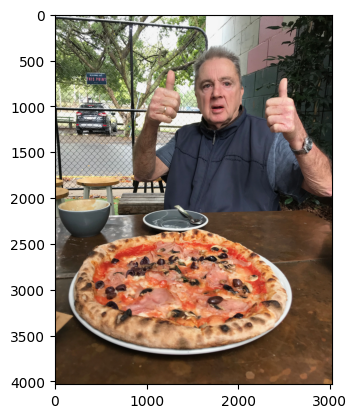

In [274]:
plt.imshow(custom_image_uint8.permute(1,2,0))

In [275]:
print(f"Custom image tensor: \n {custom_image_uint8}")
print(f"Custom image shape: {custom_image_uint8.shape}")
print(f"Custom image datatype: {custom_image_uint8.dtype}")

Custom image tensor: 
 tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 4032, 3024])
Custom image dat

### 11.2 Making a prediction on custom image with trained PyTorch model

In [276]:
# Try to make a prediction on an image in unint8 format.
model_1.eval()
with torch.inference_mode():
  model_1(custom_image_uint8.to(device))

RuntimeError: ignored

In [277]:
# let's try to fix this.  
# load in custom image and convert to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

custom_image

tensor([[[154., 173., 181.,  ...,  21.,  18.,  14.],
         [146., 165., 181.,  ...,  21.,  18.,  15.],
         [124., 146., 172.,  ...,  18.,  17.,  15.],
         ...,
         [ 72.,  59.,  45.,  ..., 152., 150., 148.],
         [ 64.,  55.,  41.,  ..., 150., 147., 144.],
         [ 64.,  60.,  46.,  ..., 149., 146., 143.]],

        [[171., 190., 193.,  ...,  22.,  19.,  15.],
         [163., 182., 193.,  ...,  22.,  19.,  16.],
         [141., 163., 184.,  ...,  19.,  18.,  16.],
         ...,
         [ 55.,  42.,  28.,  ..., 107., 104., 103.],
         [ 47.,  38.,  24.,  ..., 108., 104., 102.],
         [ 47.,  43.,  29.,  ..., 107., 104., 101.]],

        [[119., 138., 147.,  ...,  17.,  14.,  10.],
         [111., 130., 145.,  ...,  17.,  14.,  11.],
         [ 87., 111., 136.,  ...,  14.,  13.,  11.],
         ...,
         [ 35.,  22.,   8.,  ...,  52.,  52.,  48.],
         [ 27.,  18.,   4.,  ...,  50.,  49.,  44.],
         [ 27.,  23.,   9.,  ...,  49.,  46.,  43.]]]

In [278]:
custom_image.shape

torch.Size([3, 4032, 3024])

In [279]:
model_1.eval()
with torch.inference_mode():
  model_1(custom_image.to(device))

RuntimeError: ignored

In the previous dataset, our images tensors are in range 0 to 1, but here we see that the image tensor is in form of 0 to 255.

So , we divide the custom image tensor to 255, and make image tensor data between 0 to 1.



In [280]:
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)/255

custom_image

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

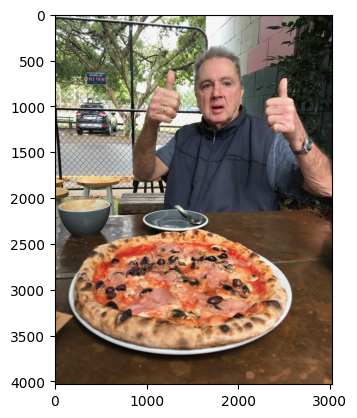

In [281]:
plt.imshow(custom_image.permute(1,2,0))

In [282]:
custom_image.shape



torch.Size([3, 4032, 3024])

In [283]:
# Create transform pipeline to resize the image
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64,64))
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out the shape
print(f"Original shape: {custom_image.shape}")
print(f"After transformation: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
After transformation: torch.Size([3, 64, 64])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


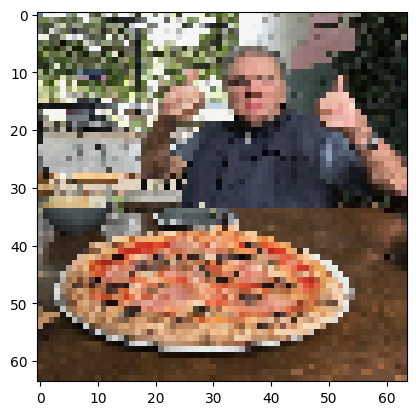

In [284]:
# plot our transform image
plt.imshow(custom_image_transformed.permute(1,2,0))

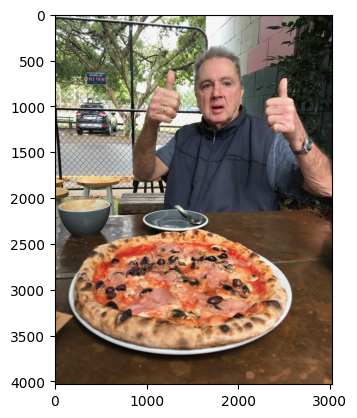

In [285]:
plt.imshow(custom_image.permute(1,2,0))

In [286]:
# This will erro , no batch size
model_1.eval()

with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.to(device))

RuntimeError: ignored

In [287]:
custom_image_transformed.shape

torch.Size([3, 64, 64])

In [288]:
custom_image_transformed.unsqueeze(0).shape

torch.Size([1, 3, 64, 64])

In [289]:
# This should work, added batch size
model_1.eval()

with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))

custom_image_pred

tensor([[0.0233, 0.0013, 0.0073]], device='cuda:0')

In [290]:
class_names

['pizza', 'steak', 'sushi']

Note, to make a prediction on a custom image we had to:

* Load the image and turned it into a tensor.

* Make sure the image was the same datatype as the model (torch.float32)

* Make sure the image was the same shape as the data the model was trained on (3,64,64) with the batch size (1,3,64,64).

* Make sure image was on the same device as our model.

In [291]:
# Convert logits to prediction labels
# logits -> prediction prob-> prediction labels
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.3376, 0.3302, 0.3322]], device='cuda:0')

In [294]:
# convert the prediction probs to prediction labels
custom_image_pred_labels = torch.argmax(custom_image_pred_probs, dim=1)
custom_image_pred_labels

tensor([0], device='cuda:0')

In [295]:
class_names[custom_image_pred_labels]

'pizza'

### 11.3 Putting custom image prediction together : building function

A function where we pass an image path and we have our model predict on that image and plot the image + prediction.

In [301]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform = None,
                        device = device):
  """ Make the prediction on target image with a trained model and plots the image and prediction. """
  # Load in the image 
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  # Divide image pixel values to 255 to get them between 0 to 1
  target_image =  target_image / 255.

  
  # Transform our data if necessary
  if transform:
    target_image = transform(target_image)

  # Make sure model is on the target device
  model.to(device)

  # Turn on inference mode / eval mode
  model.eval()
  with torch.inference_mode():
    # Add an extra dimension to the image e.g our model will predict on batches of 1 * image
    target_image = target_image.unsqueeze(0)

    # Make a prediction on the image with an extra dimension
    target_image_pred = model(target_image.to(device)) # Make sure target image is on the right device
  

  # Convert logits -> prediction probs
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # Convert prediction probs -> prediction labels
  target_image_labels = torch.argmax(target_image_pred_probs, dim=1)

  # Plot the image along side the prediction and prediction prob
  plt.imshow(target_image.squeeze().permute(1,2,0)) # remove batch dimension and rearrange shape to hwc
  if class_names:
    title = f"Pred : {class_names[target_image_labels.cpu()]} | Prediction probs : {target_image_pred_probs.max().cpu():.3f}"
  else:
    title = f"Pred: {target_image_labels} | Prediction probs: {target_image_pred_probs.max().cpu():.3f}"
  plt.title(title)
  plt.axis(False)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


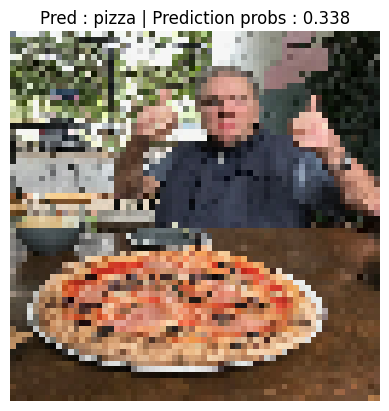

In [304]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=str(custom_image_path),
                    class_names = class_names,
                    transform = custom_image_transform,
                    device=device
)